# Final Project: HR Analytics - Employee Promotion Prediction
Margarita Espinoza  [maes2069@colorado.edu]  
CSPB 3022 - Spring 2023

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.stats import bernoulli
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn


# Project Topic  

This project is a classification problem, set to predict whether an employee in a mulit-national company is likely to be promoted or not after the Naive Bayesian process. This problem is important to solve because it will uncover the features and values that will increase an employees likelyhood of being promoted, allowing empoloyees at this company to prepare and set goals that align with our findings.

My goal is to predict if a candidate will be promoted or not and to use that information to add a column titled 'prediction' with a binary identifier for each candidate and then compare its accuracy to the actual 'is_promoted' column.

I hope to learn details about this company's promotion criteria and how features that are controllable by the employee (such as education and number of trainings completed) and uncontrollable (like age and gender) impact their probability of being promoted.

### Bonus  

By adding a second model and splitting the dataset into two - by controllable and uncontrollable features, I may uncover trends about this company's promomtion criteria that may be questionable or undesireable. In my opinion this is a more interesting approach than a generic predictive model from an entire dataset.

# Data  

**About Dataset**  
This dataset was found on Kaggle and originates from a large multi-national company wanting to identify potential promotion candidates across their organization in order to expedite the hiring process. Multiple attributes have been provided around Employee's past and current performance along with demographics to evaluate eligibility.
 

**Features:**  

- employee_id: Unique ID for employee (int64)
- department: Department of employee (object)
- region: Region of employment (unordered) (object)
- education: Education Level (object)
- gender: Gender of Employee (object)
- recruitment_channel: Channel of recruitment for employee (object)
- no_ of_ trainings: no of other trainings completed in previous year on soft skills, technical skills etc. (int64)
- age: Age of Employee (int64)
- previous_ year_ rating: Employee Rating for the previous year (float64)
- length_ of_ service: Length of service in years (int64)
- awards_ won?: if awards won during previous year then 1 else 0 (int64)
- avg_ training_ score: Average score in current training evaluations (int64)
- is_promoted: Recommended for promotion binary (int64)

**Table Data:**

- Rows: 54808
- Columns: 13
- File Size is: 3696576 bytes
- Feature Types: 8 numeric features, 5 categorical features.

In [2]:
dataset = pd.read_csv('HRAnalytics_train.csv')
dataset.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0


In [3]:
print('Rows:', np.shape(dataset)[0])
print('Columns:', np.shape(dataset)[1])
print("File Size is:", os.path.getsize('HRAnalytics_train.csv'), "bytes")
print("Column Types:")
dataset.info()

Rows: 54808
Columns: 13
File Size is: 3696576 bytes
Column Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ M

# Data Cleaning

**Data Cleaning & Reduction:**  
To clean this dataset I intend to perform the following tasks:  
- Replace all null values with generic zero values to allow for seamless numeric calculations.  
- Remove unnecessary columns such as 'recruitment_channel' and 'department' to reduce the size of the dataset and create a more manageable pandas DataFrame.  
- Review all unique values in each column to determine which categorical columns to convert into numerical values to assist with Bayesian Classification.   
- Decide which features to use in each model and create new dataframes.  

In [4]:
# Review columns with null values
dataset.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [5]:
clean_dataset = dataset

# Replacing NULL values
clean_dataset['education'] = clean_dataset['education'].fillna('N/A')
clean_dataset['previous_year_rating'] = clean_dataset['previous_year_rating'].fillna(0)

# Removing unnecessary columns
clean_dataset = clean_dataset.drop("recruitment_channel", axis='columns')
clean_dataset = clean_dataset.drop("region", axis='columns')
clean_dataset = clean_dataset.drop("employee_id", axis='columns')
clean_dataset = clean_dataset.drop("department", axis='columns')

## Review num of unique vals in each column (Cardinality)
columns = clean_dataset.columns
for var in columns:
    print(var, ':', len(clean_dataset[var].unique()))

education : 4
gender : 2
no_of_trainings : 10
age : 41
previous_year_rating : 6
length_of_service : 35
awards_won? : 2
avg_training_score : 61
is_promoted : 2


In [6]:
## Review Unique Values of Strings
print('CATEGORICAL VALUES:')
for vals in columns:
    if clean_dataset[vals].dtypes == 'O':
        print(vals,":", clean_dataset[vals].unique())

## Review the mean value of each numeric feature
print('\nNUMERIC COLUMN MEANS:')  
for vals in columns:
    if clean_dataset[vals].dtypes != 'O':
            print(vals,":", clean_dataset[vals].mean())  

CATEGORICAL VALUES:
education : ["Master's & above" "Bachelor's" 'N/A' 'Below Secondary']
gender : ['f' 'm']

NUMERIC COLUMN MEANS:
no_of_trainings : 1.253010509414684
age : 34.80391548679025
previous_year_rating : 3.0787476280834913
length_of_service : 5.865512333965844
awards_won? : 0.023171799737264635
avg_training_score : 63.38675010947307
is_promoted : 0.08517004816815063


In [7]:
## Convert categorical features to numeric
clean_dataset['gender'] = np.where(clean_dataset['gender'] == 'm', 1, 0)
   
clean_dataset['education'] = clean_dataset['education'].replace(to_replace = "N/A", value=0)
clean_dataset['education'] = clean_dataset['education'].replace(to_replace = "Below Secondary", value=1)
clean_dataset['education'] = clean_dataset['education'].replace(to_replace = "Bachelor's", value=2)
clean_dataset['education'] = clean_dataset['education'].replace(to_replace = "Master's & above", value=3)

clean_dataset.head()

,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,3,0,1,35,5.0,8,0,49,0
1,2,1,1,30,5.0,4,0,60,0
2,2,1,1,34,3.0,7,0,50,0
3,2,1,2,39,1.0,10,0,50,0
4,2,1,1,45,3.0,2,0,73,0


In [8]:
clean_dataset['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [9]:
## Create 2 Dataframes to fit to use in our model

## Controllable Features
contr_data = clean_dataset[['education', 'no_of_trainings', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 'is_promoted']]
print('CONTROLLABLE FEATURES:')
print(contr_data.info())

## Uncontrollable Features
uncontr_data = clean_dataset[['age', 'gender', 'is_promoted']]
print('\nUNCONTROLLABLE FEATURES:')
print(uncontr_data.info())


CONTROLLABLE FEATURES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   education             54808 non-null  int64  
 1   no_of_trainings       54808 non-null  int64  
 2   previous_year_rating  54808 non-null  float64
 3   length_of_service     54808 non-null  int64  
 4   awards_won?           54808 non-null  int64  
 5   avg_training_score    54808 non-null  int64  
 6   is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 MB
None

UNCONTROLLABLE FEATURES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          54808 non-null  int64
 1   gender       54808 non-null  int64
 2   is_promoted  54808 non-null  int64
dtypes: int64(3)
memo

In [10]:
## Create variables with column names for future reference
contr_cols = contr_data.columns
uncontr_cols = uncontr_data.columns

print(contr_cols)
print(uncontr_cols)

Index(['education', 'no_of_trainings', 'previous_year_rating',
       'length_of_service', 'awards_won?', 'avg_training_score',
       'is_promoted'],
      dtype='object')
Index(['age', 'gender', 'is_promoted'], dtype='object')


# Exploratory Data Analysis & Visualizations

Below are visualizations to explore the data in my dataset, starting with the breakdown of employees in features that only have a few variables.

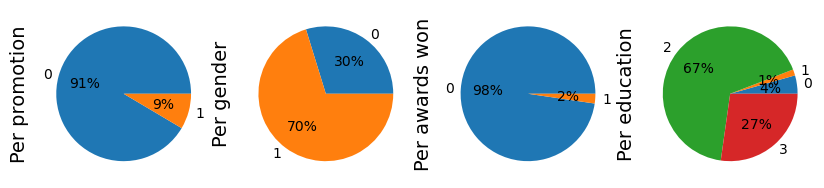

In [11]:
def label_function(val):
    return f'{val:.0f}%'

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(10, 5))

uncontr_data.groupby('is_promoted').size().plot(kind='pie', autopct=label_function, ax=ax1);
uncontr_data.groupby('gender').size().plot(kind='pie', autopct=label_function, ax=ax2);
contr_data.groupby('awards_won?').size().plot(kind='pie', autopct=label_function, ax=ax3);
contr_data.groupby('education').size().plot(kind='pie', autopct=label_function, ax=ax4);

ax1.set_ylabel('Per promotion', size=14)
ax2.set_ylabel('Per gender', size=14)
ax3.set_ylabel('Per awards won', size=14)
ax4.set_ylabel('Per education', size=14)

plt.show()
plt.show()

According to the pie charts above we can see that there are very few employees eligible for promotion. We can also see that 70% of the employees in this data set are male, the majority of employees have a Bachelor's degree, and only 2% of empoloyees have won awards.  

Next we will plot a histogram of each feature to get an idea of how they are distributed.

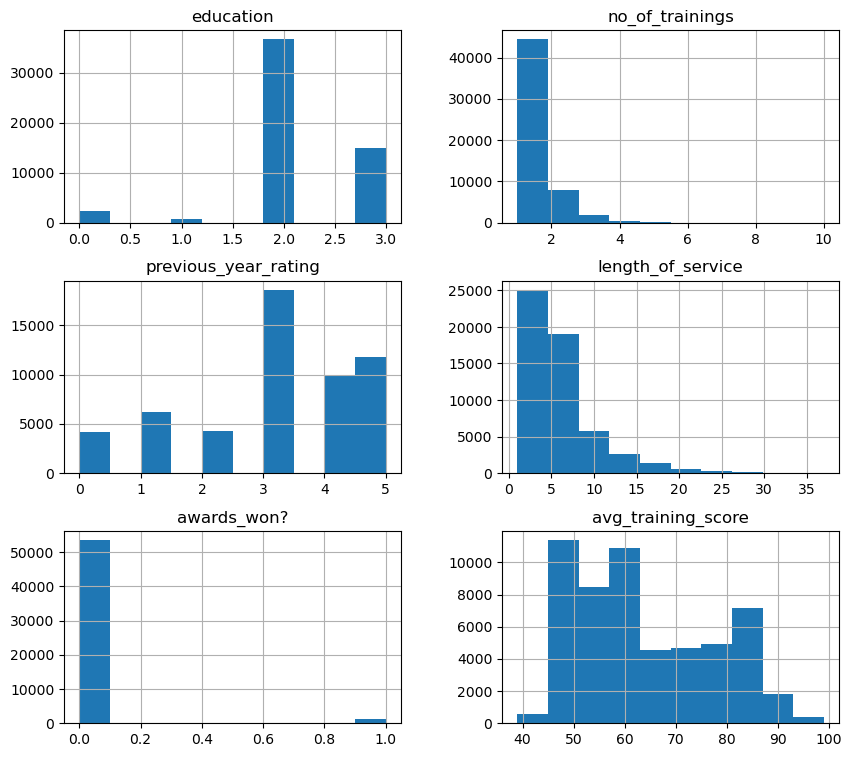

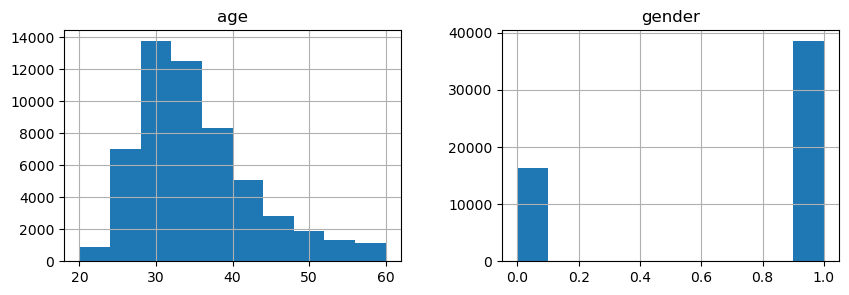

In [12]:
contr_data[['education', 'no_of_trainings', 'previous_year_rating',
       'length_of_service', 'awards_won?', 'avg_training_score']].hist(figsize=(10,9));
uncontr_data[['age', 'gender']].hist(figsize=(10,3));


We can see that there are varying distributions of data across these datasets. I will revist this later in the EDA process. 

Below is a correlation matrix for each of my controllable and uncontrollable datasets. 

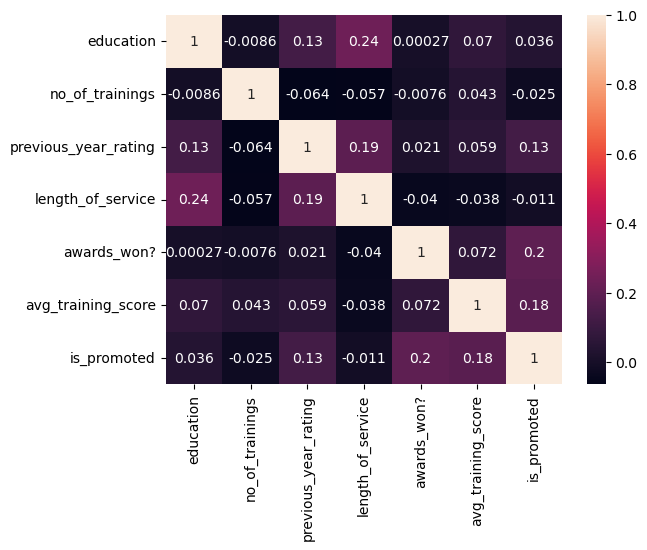

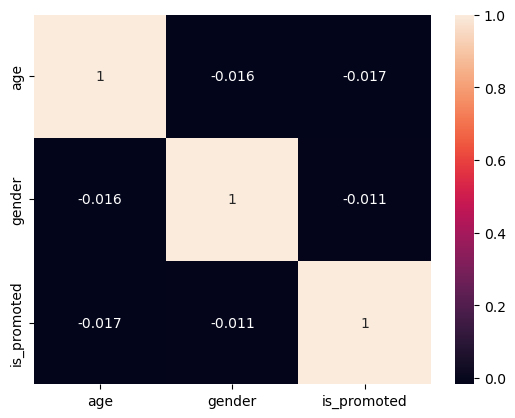

In [13]:
corr_matrix1 = contr_data.corr()
corr_matrix2 = uncontr_data.corr()

sn.heatmap(corr_matrix1, annot=True);
plt.show();
sn.heatmap(corr_matrix2, annot=True);
plt.show();

At first glance we can see that there are no obvious correlations between being promoted and our uncontrollable features, this is expected for a diverse and equitable workplace. However, our controllable features to have features that vary in correlation to being promoted.

Below are pair plots for each of my datasets, this give us a better idea of the correlations across each combination of features.

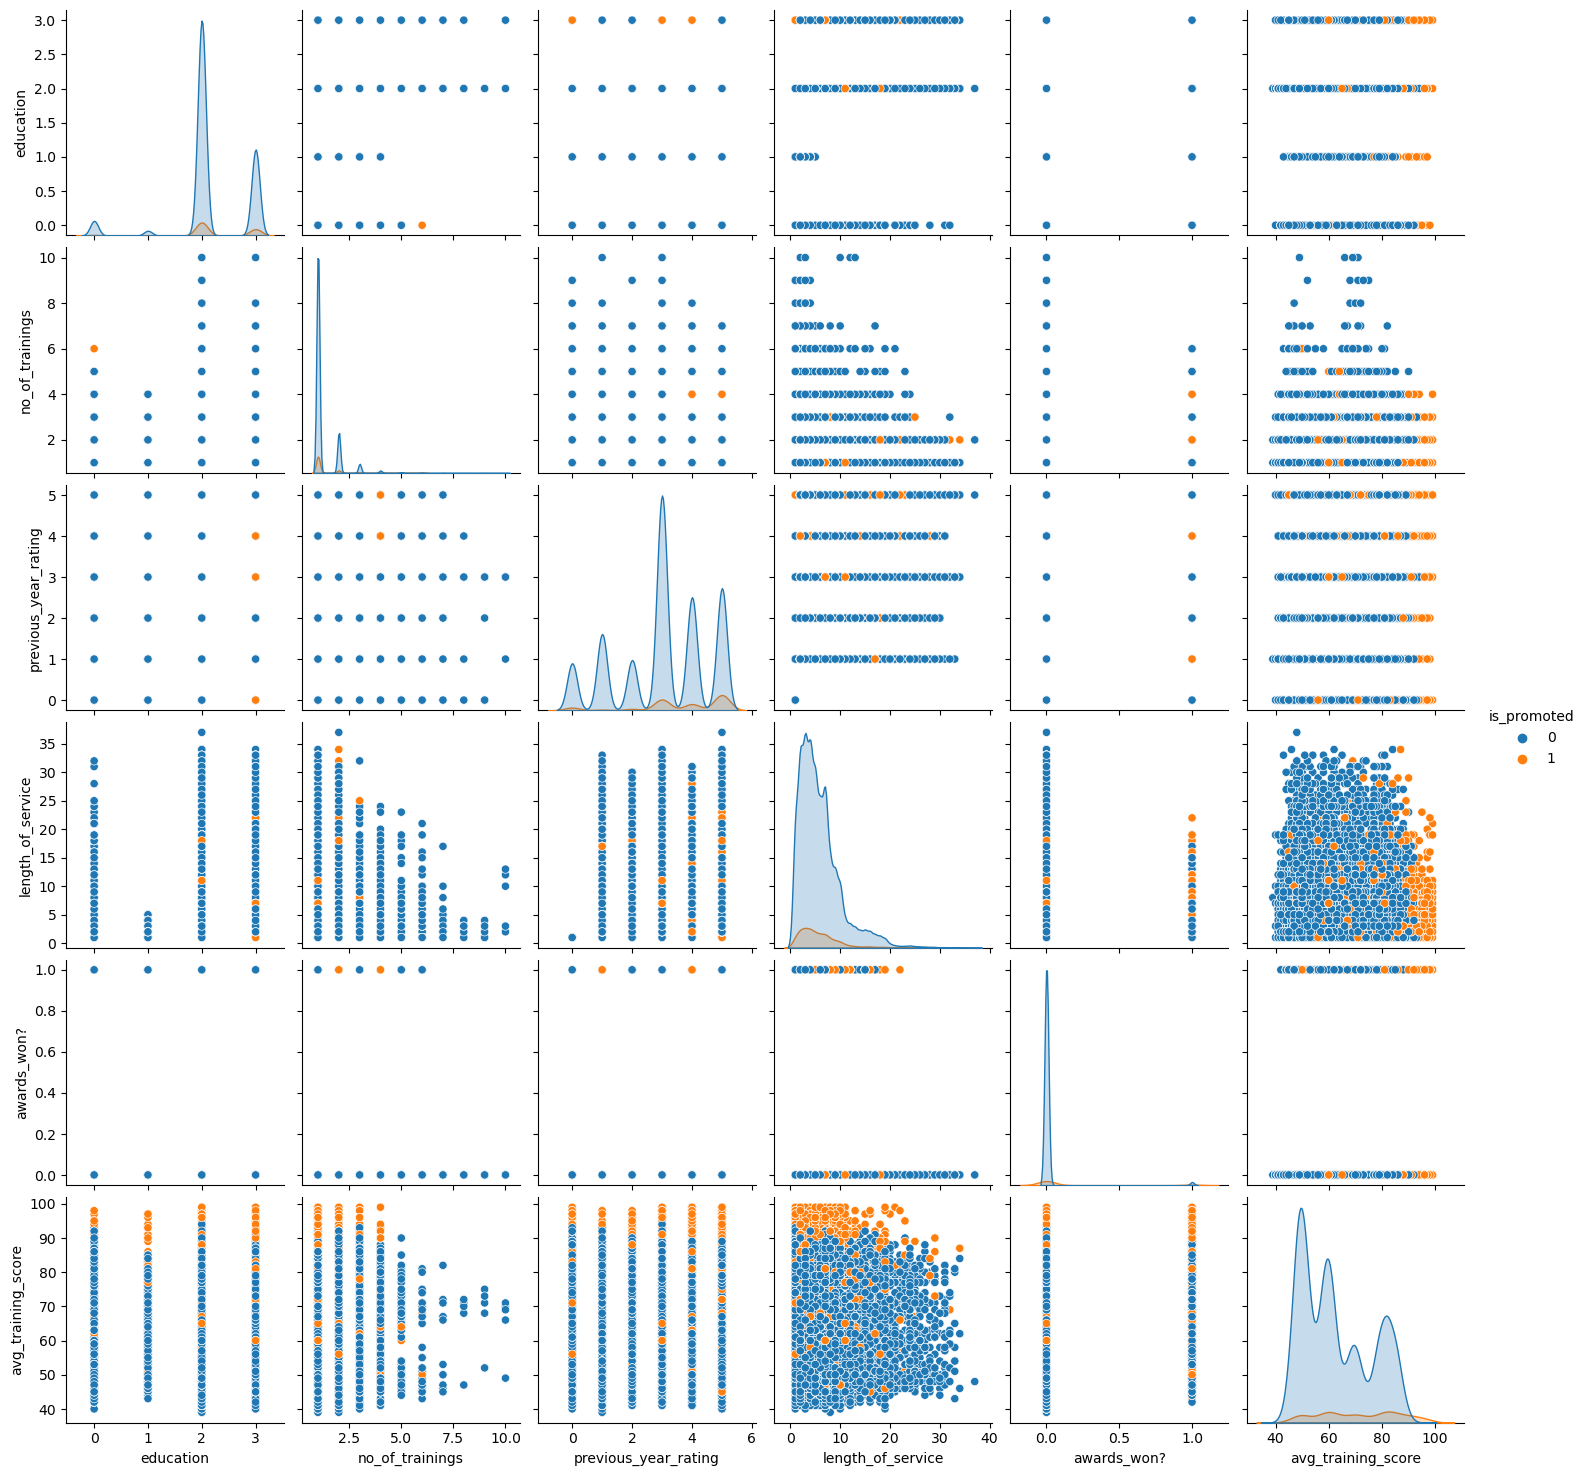

In [14]:
sn.pairplot(contr_data, hue='is_promoted')
plt.show()

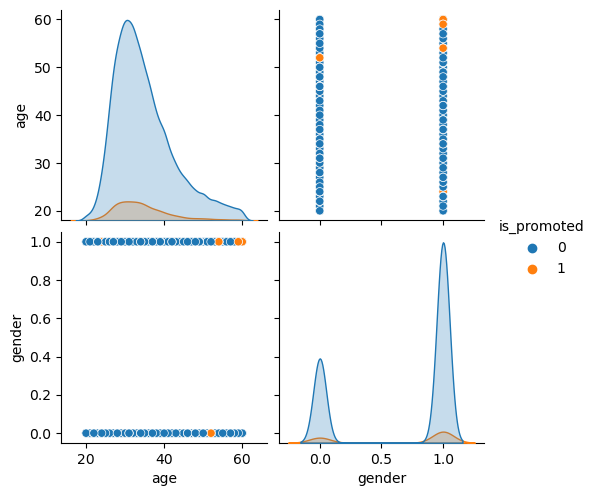

In [15]:
sn.pairplot(uncontr_data, hue='is_promoted')
plt.show()

### Normal Distributions and Bernoulli Distributions

Based on my visualizations above, my assumption is that all of my features are either normal or Bernoulii distributed, see my histograms and KDE plots below.

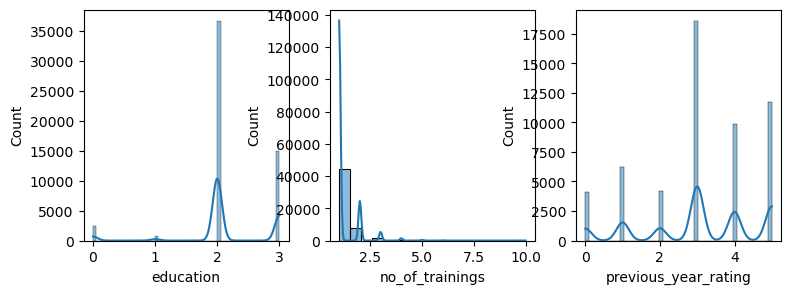

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,3))

sn.histplot(contr_data['education'], kde=True, ax=ax1);
sn.histplot(contr_data['no_of_trainings'], kde=True, ax=ax2);
sn.histplot(contr_data['previous_year_rating'], kde=True, ax=ax3);


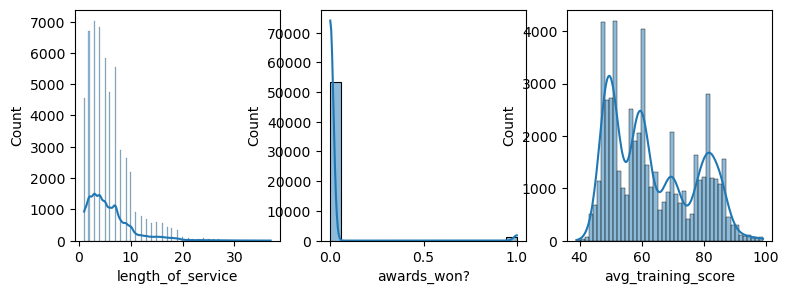

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,3))

sn.histplot(contr_data['length_of_service'], kde=True, ax=ax1);
sn.histplot(contr_data['awards_won?'], kde=True, ax=ax2);
sn.histplot(contr_data['avg_training_score'], kde=True, ax=ax3);


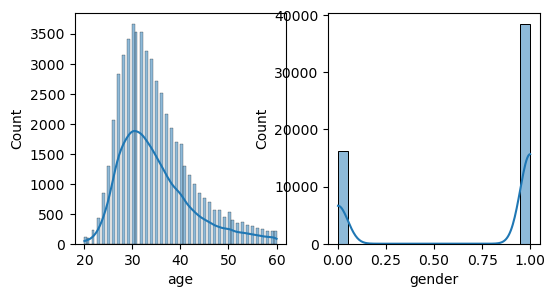

In [18]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))

sn.histplot(uncontr_data['age'], kde=True, ax=ax1);
sn.histplot(uncontr_data['gender'], kde=True, ax=ax2);


**EDA Summary**  
After exploring the dataset, we have a basic understanding of employee performance and demographics of this company and the types of employees that have been promoted. So far we have only identified a correlation between being promoted and controllable features, but how do the uncontrollable features impact employee performance? I have had a difficult time finding comprehensive visualizations for binary data, but as you can see above - the pie charts and pair plots appear to be the most telling.  

In regards to distributions, you can see that the features we have selected fall into either a normal or Bernoulli distribution.  

# Model Approach: Bayes Classification

**First Attempt:**  
For my first model approach I have selected to use Gaussian Bayesian Classification model which uses Bayes Theorem to predict if each employee will be promoted or not.

### Build the model with the controllable features

In [19]:
## Create our test and train datasets for the controllable dataset
X = contr_data.drop(['is_promoted'], axis=1)
y = contr_data['is_promoted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Train our classification model using the GaussianNB()
gnb=GaussianNB() 
gnb.fit(X_train,y_train) 

# Make predictions
y_pred=gnb.predict(X_test)

print('Classification Report:')
print(classification_report(y_test,y_pred, zero_division=0))

# Print the number of promotions, predictions and actual
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the probability of correcly predicting promotion
print('\nNaive Bayes score:')
print(gnb.score(X_test, y_test))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     15057
           1       0.44      0.13      0.20      1386

    accuracy                           0.91     16443
   macro avg       0.68      0.56      0.58     16443
weighted avg       0.88      0.91      0.89     16443

Confusion Matrix:
[[14834   223]
 [ 1209   177]]

Naive Bayes score:
0.9129112692331083


In [20]:
## Compare the predictions to actual data in a new dataset
contr_prob_data = X_test
contr_prob_data['prediction'] = y_pred
contr_prob_data['is_promoted'] = y_test

contr_prob_data['match?'] = np.where((contr_prob_data['prediction'] >= contr_prob_data['is_promoted']) & (contr_prob_data['prediction'] <= contr_prob_data['is_promoted']),1 , 0)


## Calculate the difference
total_rows = contr_prob_data.count()[0]
match_count = contr_prob_data.loc[contr_prob_data['match?'] == 1].count()[0]
print('Count of accurate predictions:', match_count)
print('Total employees:', total_rows)
print('Difference:', total_rows-match_count)
print('Probability:', match_count/total_rows)

## Review the details
print('\nDifference Breakdown:')
grp_data1 = contr_prob_data.groupby(['is_promoted', 'prediction'])['match?'].count()
print(grp_data1)

Count of accurate predictions: 15011
Total employees: 16443
Difference: 1432
Probability: 0.9129112692331083

Difference Breakdown:
is_promoted  prediction
0            0             14834
             1               223
1            0              1209
             1               177
Name: match?, dtype: int64


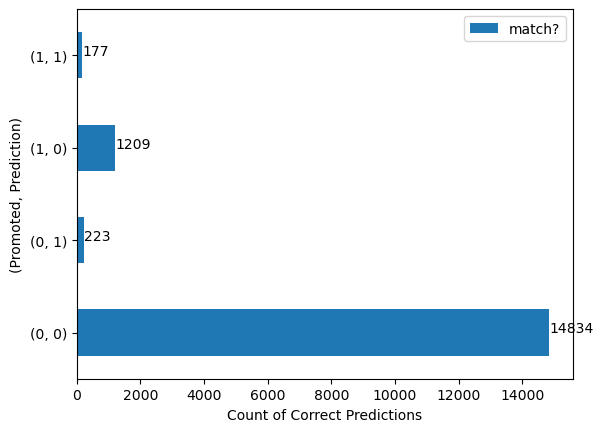

In [21]:
## Plot the predictions vs actual     
grp_data1.plot(kind='barh', ylabel='(Promoted, Prediction)', xlabel='Count of Correct Predictions');

for index, value in enumerate(grp_data1):
    plt.text(value, index,str(value))
plt.legend();
plt.show();


**Controllable Feature Conclusion:**  
By plotting our predictions vs actual promotions above, we can see that we have correctly predicted 14,834 employees that will NOT be promoted and 177 employees that will be promoted, which leaves 1,432 incorrect predictions. This means the probability of our model correctly predicting a promotion is 91%!  

What does this say about our model? Is this the best model to use for this dataset? With 91% probability - I would say yes.

### Build the model with the uncontrollable features

In [22]:
## Create our test and train datasets for the controllable dataset
X = uncontr_data.drop(['is_promoted'], axis=1)
y = uncontr_data['is_promoted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# Train our classification model using the GaussianNB()
gnb=GaussianNB() 
gnb.fit(X_train,y_train) 

# Make predictions
y_pred=gnb.predict(X_test)

print('Classification Report:')
print(classification_report(y_test,y_pred, zero_division=0))

# Print the number of promotions, predictions and actual
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Print the probability of correcly predicting promotion
print('\nNaive Bayes score:')
print(gnb.score(X_test, y_test))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     15057
           1       0.00      0.00      0.00      1386

    accuracy                           0.92     16443
   macro avg       0.46      0.50      0.48     16443
weighted avg       0.84      0.92      0.88     16443

Confusion Matrix:
[[15057     0]
 [ 1386     0]]

Naive Bayes score:
0.9157088122605364


In [23]:
## Compare the predictions to actual data in a new dataset
uncontr_prob_data = X_test
uncontr_prob_data['prediction'] = y_pred
uncontr_prob_data['is_promoted'] = y_test

uncontr_prob_data['match?'] = np.where((uncontr_prob_data['prediction'] >= contr_prob_data['is_promoted']) & (contr_prob_data['prediction'] <= contr_prob_data['is_promoted']),1 , 0)


## Calculate the difference
total_rows = uncontr_prob_data.count()[0]
match_count = uncontr_prob_data.loc[uncontr_prob_data['match?'] == 1].count()[0]
print('Count of accurate predictions:', match_count)
print('Total employees:', total_rows)
print('Difference:', total_rows-match_count)
print('Probability:', match_count/total_rows)

## Review the details
print('\nDifference Breakdown:')
grp_data2 = uncontr_prob_data.groupby(['is_promoted', 'prediction'])['match?'].count()
print(grp_data2)

Count of accurate predictions: 14834
Total employees: 16443
Difference: 1609
Probability: 0.9021468101927872

Difference Breakdown:
is_promoted  prediction
0            0             15057
1            0              1386
Name: match?, dtype: int64


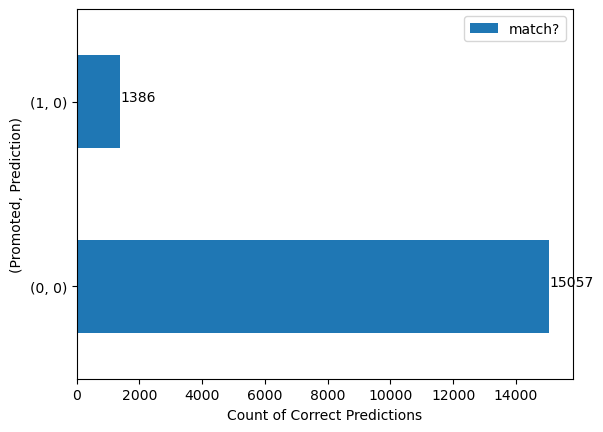

In [24]:
## Plot the predictions vs actual     
grp_data2.plot(kind='barh', ylabel='(Promoted, Prediction)', xlabel='Count of Correct Predictions');

for index, value in enumerate(grp_data2):
    plt.text(value, index,str(value))
plt.legend();
plt.show();


**Unontrollable Feature Conclusion:**  
By plotting our predictions vs actual promotions above, we can see that we have correctly predicted 15,057 employees that will NOT be promoted and 0 employees that will be promoted, our model did not predict that anyone would be promoted. Even with this skewed predition, the probability of our model correctly predicting a promotion is still 90%.  

What does this say about our model? Is this the best model to use for this dataset? With 91% probability but zero promotion predictions - I would say probably not. It does however prove that this company is NOT promoting based on uncontrollable features like age and gender. 

For part 3 of the project I will explore what other types of models we can use to evaluate this dataset.

### References

MÖBIUS. (2021, January 10). HR Analytics: Employee Promotion Data. Kaggle. https://www.kaggle.com/datasets/arashnic/hr-ana  

Banerjee, P. (2020, August 27). Naive Bayes Classifier in Python. Kaggle. https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python  

AssemblyAI. (2022, September 17). How to implement Naive Bayes from scratch with Python. Youtube. https://www.youtube.com/watch?v=TLInuAorxqE  

Educational Research Techniques. (2022, May 6). Naive Bayes with Python. Youtube. https://www.youtube.com/watch?v=Q93IWdj5Td4  

